# To reproduce a run and investigate seasonal transition signature

In [398]:
# Import libraries
import os
import sys
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

sys.path.append("../libs/cfe_py")
from bmi_cfe import BMI_CFE

sys.path.append("../libs/SMSig")
from sig_seasontrans import SMSig

# Specify current directory create output directory if it does not exist
os.getcwd()

'g:\\Shared drives\\Ryoko and Hilary\\SMSigxModel\\analysis\\5_post_analysis'

# Configuration

In [399]:
site = "Coweeta"
case = rf"{site}-2024-03-20"


In [400]:
data_directory = rf"..\data\{site}"
config_temp_path = os.path.join(data_directory, "temporary_parameter_files_for_GLUE", "config_cfe_0.json")
prior_params_path = rf"..\3_GLUE_prerun\results\{case}\prior_parameters.csv"
evaluation_metrics_path = rf"..\3_GLUE_prerun\results\{case}\evaluation_metrics.csv"
out_path = rf".\results\{case}"
if not os.path.exists(out_path):
    os.makedirs(out_path)

# Load parameters for a run

In [401]:
eval_metrics = pd.read_csv(evaluation_metrics_path)
# eval_metrics[(eval_metrics['KGE on Soil']>0.71) & (eval_metrics['SeasonTrans of Soil dry2wet_end']>50)]
# 93, 32, 71
# eval_metrics[(eval_metrics['SeasonTrans of Soil wet2dry_start']<50)]
thresh = 30
subset = eval_metrics[(eval_metrics['SeasonTrans of Soil wet2dry_start']>=thresh)]
# subset = eval_metrics[(eval_metrics['SeasonTrans of Soil dry2wet_start']<=thresh) & (eval_metrics['SeasonTrans of Soil wet2dry_start']<=thresh)& (eval_metrics['SeasonTrans of Soil dry2wet_end']<=thresh) & (eval_metrics['SeasonTrans of Soil wet2dry_end']<=thresh)]
len(subset)
subset
# eval_metrics[(eval_metrics['KGE on Soil']>0.5)]
# run_id=190
# eval_metrics[(eval_metrics['KGE on Soil']>0.7) & (eval_metrics['SeasonTrans of Soil dry2wet_end']>50)]
# run_id=113, 9817

,run_id,NSE on Flow,NSE on Soil,KGE on Flow,KGE on Soil,SeasonTrans of Soil dry2wet_start,SeasonTrans of Soil dry2wet_end,SeasonTrans of Soil wet2dry_start,SeasonTrans of Soil wet2dry_end,SeasonTrans of Soil dry2wet_start_raw,SeasonTrans of Soil dry2wet_end_raw,SeasonTrans of Soil wet2dry_start_raw,SeasonTrans of Soil wet2dry_end_raw
0,0,-0.260130,-2.008446,0.053643,0.556665,3.377541,12.603241,45.962970,10.727121,"[3.7596373693086207, 3.345563407987356, 3.0274...","[-38.02431165520102, 1.276816711295396, -1.062...","[-33.19640025915578, -58.72954048309475, nan]","[14.459885319694877, 6.994357149582356, nan]"
1,1,-0.426277,-1.221938,0.029394,0.501970,2.690080,13.257889,50.768478,8.665157,"[2.8935582037083805, 2.1121842288412154, 3.064...","[-38.50538429291919, 0.3285118341445923, -1.59...","[-42.118495972361416, -59.41846011066809, nan]","[9.459880514536053, 7.8704325426369905, nan]"
2,2,-0.636733,-1.520492,-0.055377,0.578182,3.423533,12.781333,46.281444,10.656767,"[3.759640737436712, 3.3025677166879177, 3.2083...","[-38.00967662781477, 1.235759254079312, -1.570...","[-33.995793333277106, -58.56709519820288, nan]","[14.4598783319816, 6.8536560060456395, nan]"
3,3,-0.410943,-2.852513,0.001238,0.521541,3.390146,12.577997,45.590877,10.732304,"[3.7596430107951164, 3.3833706504665315, 3.027...","[-37.97001569205895, 1.3096908265724778, -1.07...","[-32.48112686863169, -58.70062792068347, nan]","[14.4598862468265, 7.004721085075289, nan]"
4,4,0.138686,-9.364389,0.278944,0.136342,0.016088,13.079909,54.395456,18.199860,"[1.843211161904037, -4.171275003347546, 2.2797...","[-40.91791279008612, 2.7219986245036125, -1.04...","[-57.22393642226234, -51.56697514746338, nan]","[1.7941041472367942, -38.193824641406536, nan]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,-0.107515,-1.599303,0.169982,0.575108,3.332543,12.874517,45.841438,10.517490,"[3.7596330316737294, 3.0986024192534387, 3.139...","[-38.16090192878619, 1.1826925491914153, -1.64...","[-33.11654957802966, -58.56632692972198, nan]","[14.304726927075535, 6.730253732763231, nan]"
96,96,-0.377428,-8.241854,0.020650,0.335245,3.503679,12.245851,44.451582,11.004956,"[3.760047980118543, 3.72356299078092, 3.027425...","[-37.32644447917119, 1.6559162829071283, -1.06...","[-30.33671827521175, -58.56644644308835, nan]","[15.459913593251258, 6.549998853821307, nan]"
97,97,-0.355211,0.738733,0.027381,0.661443,3.033653,13.107023,48.030773,9.992648,"[3.417867060750723, 2.5096169346943498, 3.1734...","[-38.353437467012554, 0.6091284304857254, -1.5...","[-36.8543385094963, -59.20720831397921, nan]","[12.459881821647286, 7.525414346717298, nan]"
98,98,0.190794,-5.735717,0.287593,0.279865,1.381574,13.078017,54.231971,8.127109,"[2.5725414655171335, -1.3934881989844143, 2.96...","[-39.47152671404183, 1.938775822520256, -1.701...","[-48.30703009106219, -60.156912179198116, nan]","[5.459845589939505, 10.794371413532645, nan]"


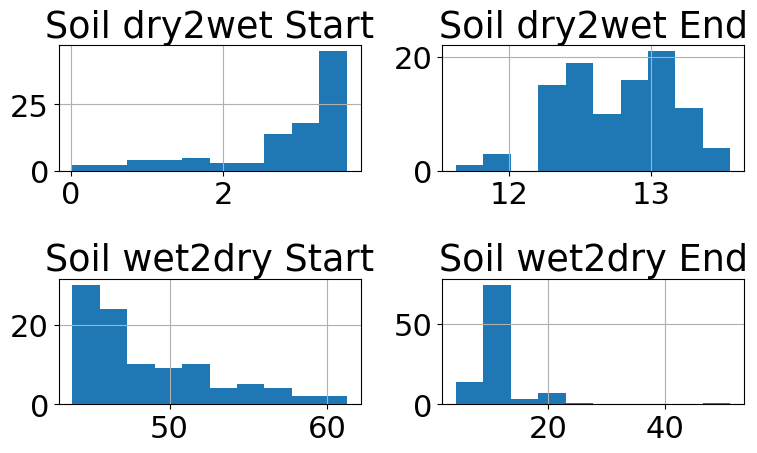

In [402]:
# Creating 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 5))

# Plotting each histogram
eval_metrics['SeasonTrans of Soil dry2wet_start'].hist(ax=axs[0, 0])
axs[0, 0].set_title('Soil dry2wet Start')

eval_metrics['SeasonTrans of Soil dry2wet_end'].hist(ax=axs[0, 1])
axs[0, 1].set_title('Soil dry2wet End')

eval_metrics['SeasonTrans of Soil wet2dry_start'].hist(ax=axs[1, 0])
axs[1, 0].set_title('Soil wet2dry Start')

eval_metrics['SeasonTrans of Soil wet2dry_end'].hist(ax=axs[1, 1])
axs[1, 1].set_title('Soil wet2dry End')

plt.tight_layout()
plt.show()

In [403]:
config_all_runs = pd.read_csv(prior_params_path)
config_all_runs.head()

,run_id,bb,satdk,slop,smcmax,wltsmc,max_gw_storage
0,0,4.116357,0.013465,0.075041,0.878130,2.307747e-07,0.203301
1,1,2.551116,0.003790,0.034931,0.783960,2.025591e-07,0.152326
2,2,4.070635,0.005299,0.046805,0.865920,1.902235e-07,0.150052
3,3,4.024067,0.012340,0.065165,0.924209,2.253066e-07,0.184768
4,4,1.526713,0.001519,0.047352,0.946360,1.659718e-07,0.182307


In [404]:

run_id = 3
config_target_runs = config_all_runs[config_all_runs["run_id"]==run_id]
print(config_target_runs)

   run_id        bb    satdk      slop    smcmax        wltsmc  max_gw_storage
3       3  4.024067  0.01234  0.065165  0.924209  2.253066e-07        0.184768


In [405]:
with open(config_temp_path, 'r') as outfile:
    config_temp = json.load(outfile)

In [406]:
for key, value in config_target_runs.items():
    if key == "run_id":
        None
    elif key in ['bb', 'satdk', 'slop', 'satpsi', 'smcmax', 'wltsmc', 'D']:
        config_temp["soil_params"][key] = value.values[0]
    else:
        config_temp[key] = value.values[0]
config_temp

{'forcing_file': 'G:/Shared drives/Ryoko and Hilary/SMSigxModel/analysis/data/Coweeta/forcing_daily_2014_2018.csv',
 'catchment_area_km2': 0.121,
 'soil_params': {'bb': 4.024067319125196,
  'satdk': 0.0123397083314508,
  'slop': 0.0651646977221501,
  'satpsi': 0.141,
  'smcmax': 0.9242087446229004,
  'wltsmc': 2.2530658172953845e-07,
  'D': 0.6},
 'max_gw_storage': 0.1847681553822743,
 'Cgw': 0.001,
 'expon': 3,
 'K_lf': 0.9784460486586726,
 'K_nash': 1e-05,
 'num_nash_storage': 2,
 'giuh_ordinates': [0.5, 0.5],
 'trigger_z_fact': 0.570054772877,
 'alpha_fc': 0.33,
 'refkdt': 3,
 'stand_alone': 1,
 'unit_test': 1,
 'time_step_size': 86400,
 'compare_results_file': 'G:/Shared drives/Ryoko and Hilary/SMSigxModel/analysis/data/Coweeta/test_daily_2014_2018_sm_basinavg.csv'}

In [407]:
temporary_config_path = "temporary_config_reproducing_run"
if not os.path.exists(temporary_config_path):
    os.makedirs(temporary_config_path)

In [408]:
temporary_config_file = os.path.join(temporary_config_path, f"config_cfe_{run_id}.json")
with open(temporary_config_file, 'w') as out_file:
    json.dump(config_temp, out_file)

# Run CFE

GW & SM converged <1% after warm-up iteration 1; diff_gw: 0.0000000; diff_sm: 0.0000000


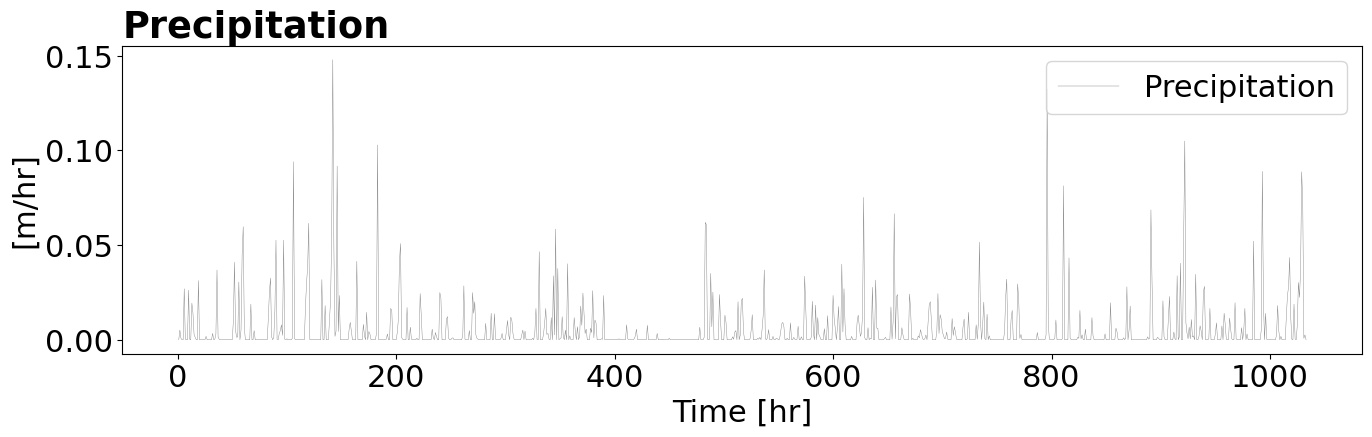

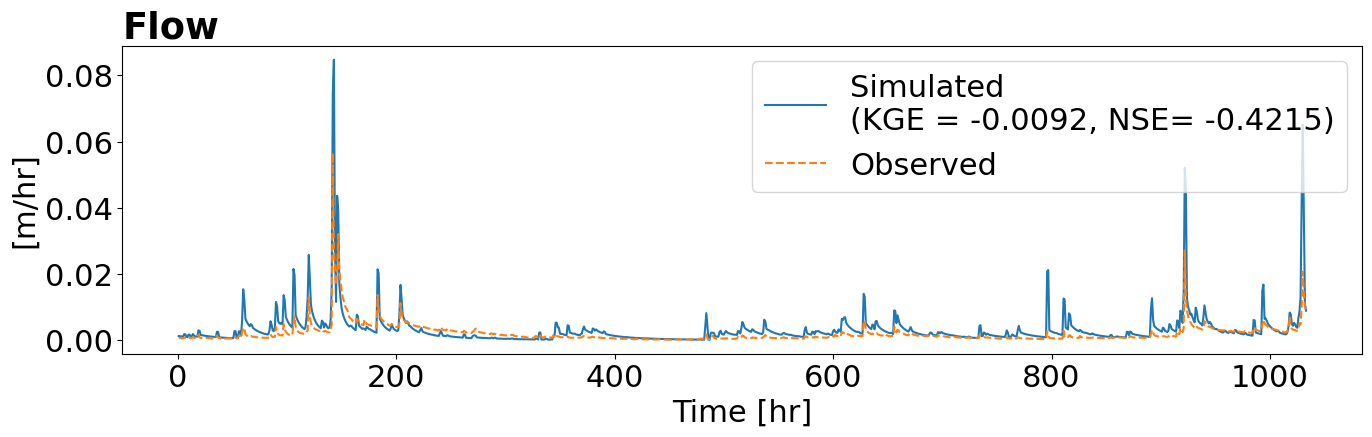

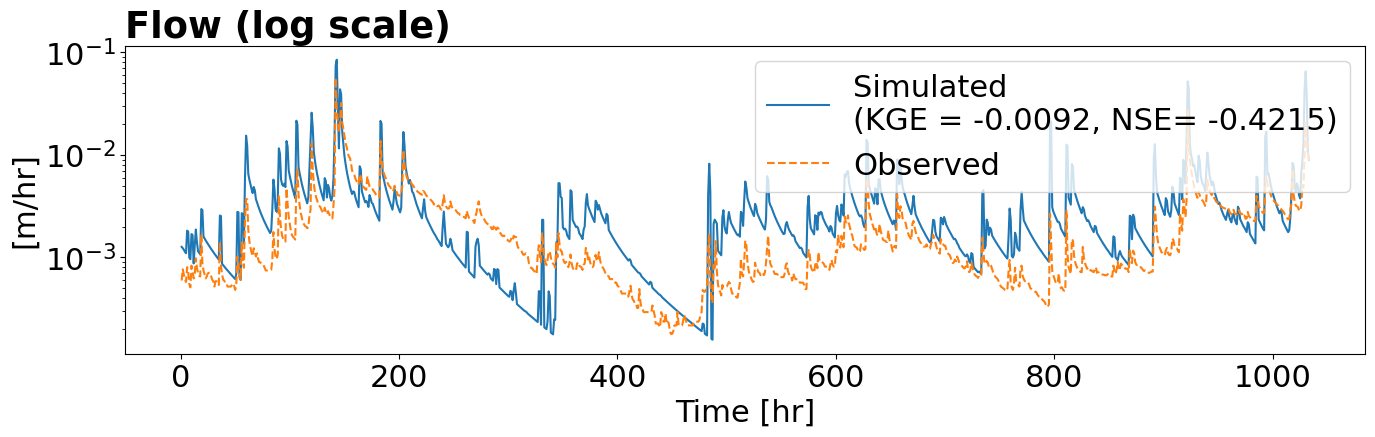

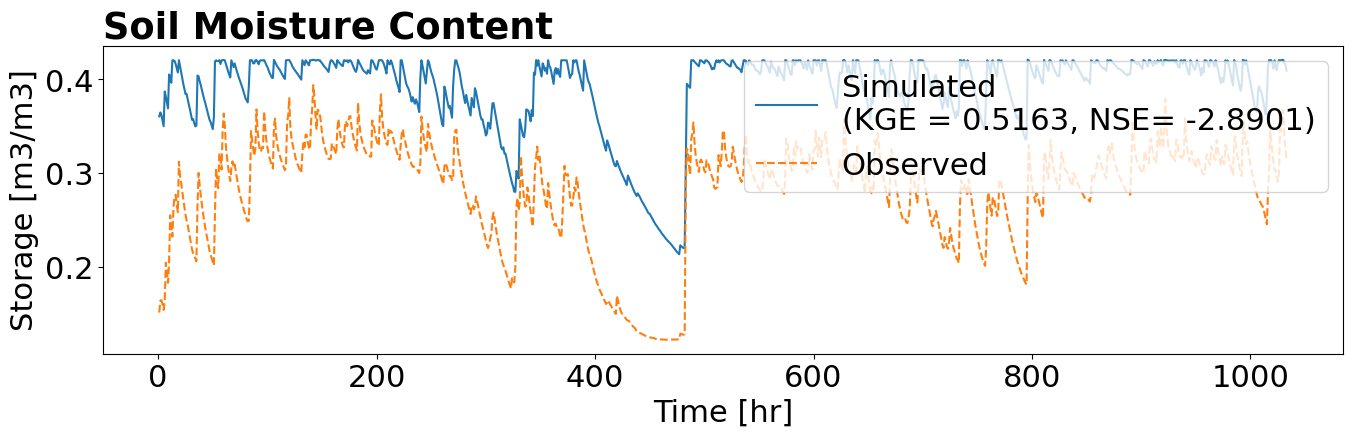

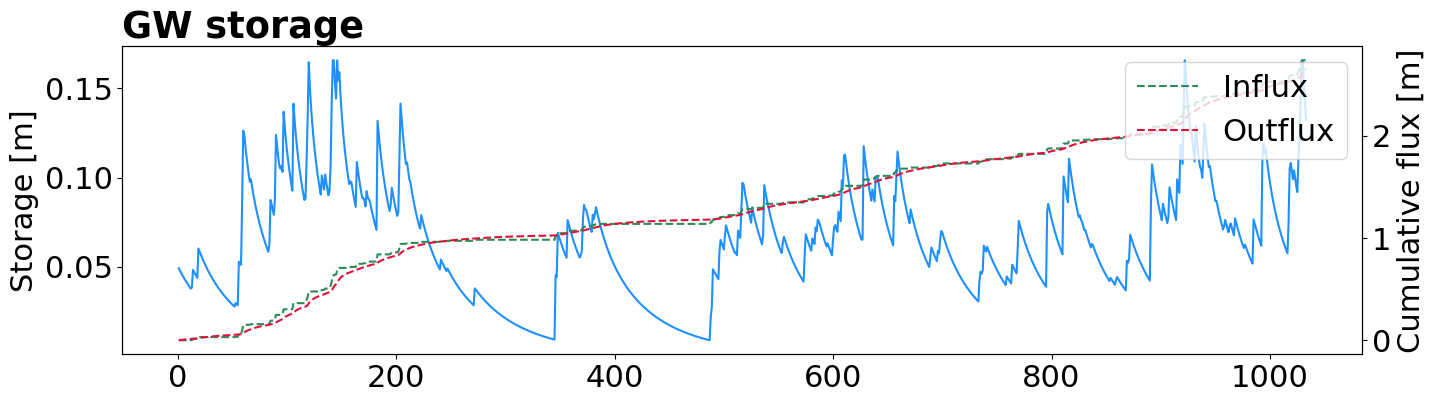

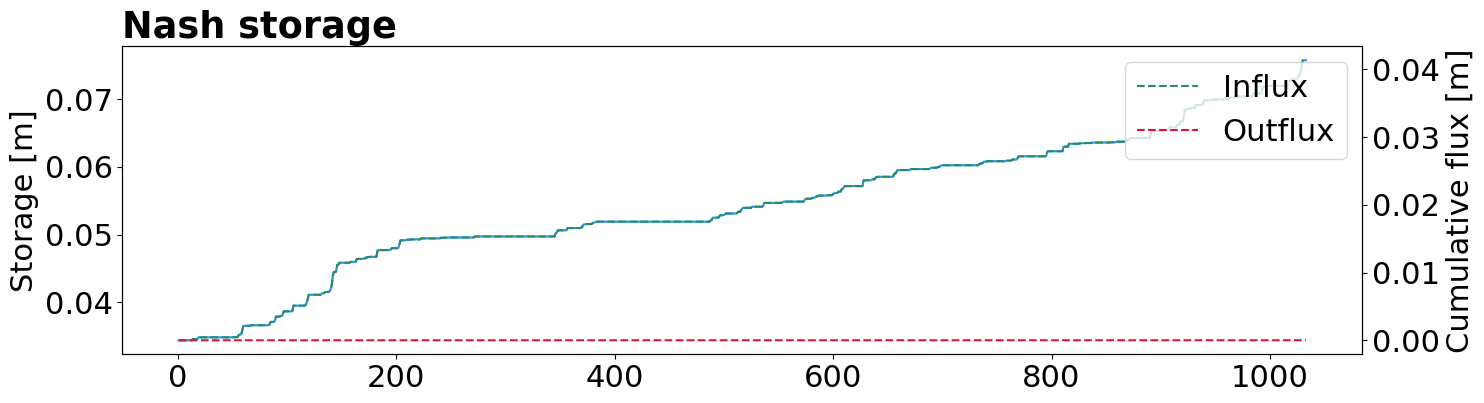

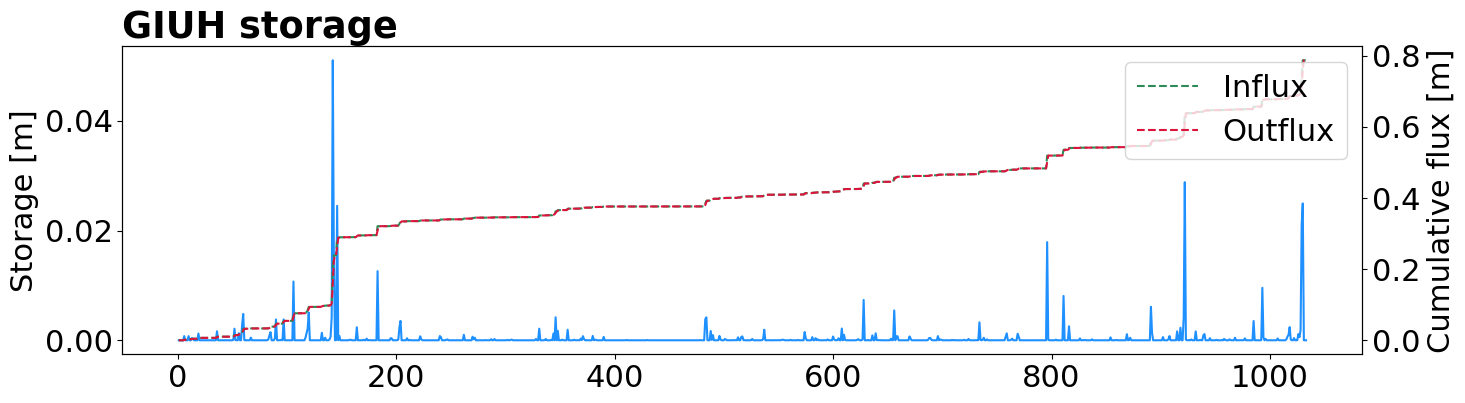

(      Soil Moisture Content
 0                  0.153545
 1                  0.151452
 2                  0.164292
 3                  0.164678
 4                  0.159843
 ...                     ...
 1030               0.366092
 1031               0.339694
 1032               0.325503
 1033               0.314286
 1034               0.304777
 
 [1035 rows x 1 columns],
       Soil Moisture Content
 0                  0.367544
 1                  0.360657
 2                  0.364727
 3                  0.361849
 4                  0.355985
 ...                     ...
 1030               0.420668
 1031               0.417403
 1032               0.415471
 1033               0.409305
 1034               0.404278
 
 [1035 rows x 1 columns])

In [409]:
# Run the CFE based on the config file
cfe_instance = BMI_CFE(temporary_config_file)
cfe_instance.initialize()
sim0 = cfe_instance.run_unit_test(plot=True,
    print_fluxes=True,
    plot_lims=list(range(1, 1034)),
    warm_up=True,
    warmup_offset=400,
    warmup_iteration=10
    )
obs0 = cfe_instance.load_unit_test_data()

# Get the results
var_name = 'Soil Moisture Content'
sim = sim0[["Time", var_name]].copy()
sim["Time"] = pd.to_datetime(sim["Time"], format="%Y-%m-%d")  # Works specifically for CFE

# Get the comparison data
obs = obs0[["Time", var_name]].copy()
obs["Time"] = pd.to_datetime(obs["Time"], format="%Y-%m-%d") 
# if study_site == "Mahurangi":
#     obs["Time"] = pd.to_datetime(obs["Time"], format="%m/%d/%Y %H:%M")  # Works specifically for Mahurangi data
# elif study_site == "LittleWashita":
#     obs["Time"] = pd.to_datetime(obs["Time"], format="%Y-%m-%d %H:%M:%S")  # works for Little ashita
# # obs["Time"] = pd.to_datetime(obs["Time"], format="%d-%m-%Y %H:%M:%S")

# Merge observed and simulated timeseries
df = pd.merge_asof(sim, obs, on="Time")

sim_synced = pd.DataFrame()
obs_synced = pd.DataFrame()
sim_synced[var_name] = df[var_name + "_x"].copy()
obs_synced[var_name] = df[var_name + "_y"].copy()

obs_synced, sim_synced

# Run seasonal signature

In [410]:
# Evaluate using seasonal soil moisture signature
sig_obs = SMSig(
    t=df["Time"].to_numpy(),
    sm=obs_synced[var_name].to_numpy(),
    plot_results=False,
)

seasonal_cycle = pd.read_csv(os.path.join(data_directory, "seasonal_cycle.csv"), parse_dates=['start_date', 'end_date'])

_parameter_config = os.path.join(data_directory, "seasonal_transition_config.json")
with open(_parameter_config, "r") as config_file:
    config = json.load(config_file)

season_trans_obs = sig_obs.calc_seasontrans(seasonal_cycle=seasonal_cycle, parameter_config=config)

sig_sim = SMSig(
    t=df["Time"].to_numpy(),
    sm=sim_synced[var_name].to_numpy(),
    plot_results=False,
)
season_trans_sim = sig_sim.calc_seasontrans(seasonal_cycle=seasonal_cycle, parameter_config=config)

# Get the deviations in seasonal transition dates between simulated and observed timeseries
diff = season_trans_sim - season_trans_obs
metric_value = abs(np.nanmean(diff, axis=0))
print(diff)
print(metric_value)



Check seasonal_cycle.csv
Check seasonal_cycle.csv
[[  3.75964546 -38.00713153   5.89627621  10.80352097]
 [  3.38337065   1.30969083 -58.70062792   7.00472108]
 [  3.02742362  -1.07366712          nan          nan]]
[ 3.39014658 12.59036927 26.40217585  8.90412102]


# Load evaluation metrics

In [411]:
result_run = pd.read_csv(evaluation_metrics_path)
KGESM_for_the_run = result_run['KGE on Soil'][result_run["run_id"]==run_id].values[0]
print(KGESM_for_the_run)
result_run.head()

0.521541450585477


,run_id,NSE on Flow,NSE on Soil,KGE on Flow,KGE on Soil,SeasonTrans of Soil dry2wet_start,SeasonTrans of Soil dry2wet_end,SeasonTrans of Soil wet2dry_start,SeasonTrans of Soil wet2dry_end,SeasonTrans of Soil dry2wet_start_raw,SeasonTrans of Soil dry2wet_end_raw,SeasonTrans of Soil wet2dry_start_raw,SeasonTrans of Soil wet2dry_end_raw
0,0,-0.260130,-2.008446,0.053643,0.556665,3.377541,12.603241,45.962970,10.727121,"[3.7596373693086207, 3.345563407987356, 3.0274...","[-38.02431165520102, 1.276816711295396, -1.062...","[-33.19640025915578, -58.72954048309475, nan]","[14.459885319694877, 6.994357149582356, nan]"
1,1,-0.426277,-1.221938,0.029394,0.501970,2.690080,13.257889,50.768478,8.665157,"[2.8935582037083805, 2.1121842288412154, 3.064...","[-38.50538429291919, 0.3285118341445923, -1.59...","[-42.118495972361416, -59.41846011066809, nan]","[9.459880514536053, 7.8704325426369905, nan]"
2,2,-0.636733,-1.520492,-0.055377,0.578182,3.423533,12.781333,46.281444,10.656767,"[3.759640737436712, 3.3025677166879177, 3.2083...","[-38.00967662781477, 1.235759254079312, -1.570...","[-33.995793333277106, -58.56709519820288, nan]","[14.4598783319816, 6.8536560060456395, nan]"
3,3,-0.410943,-2.852513,0.001238,0.521541,3.390146,12.577997,45.590877,10.732304,"[3.7596430107951164, 3.3833706504665315, 3.027...","[-37.97001569205895, 1.3096908265724778, -1.07...","[-32.48112686863169, -58.70062792068347, nan]","[14.4598862468265, 7.004721085075289, nan]"
4,4,0.138686,-9.364389,0.278944,0.136342,0.016088,13.079909,54.395456,18.199860,"[1.843211161904037, -4.171275003347546, 2.2797...","[-40.91791279008612, 2.7219986245036125, -1.04...","[-57.22393642226234, -51.56697514746338, nan]","[1.7941041472367942, -38.193824641406536, nan]"


# Plot the results

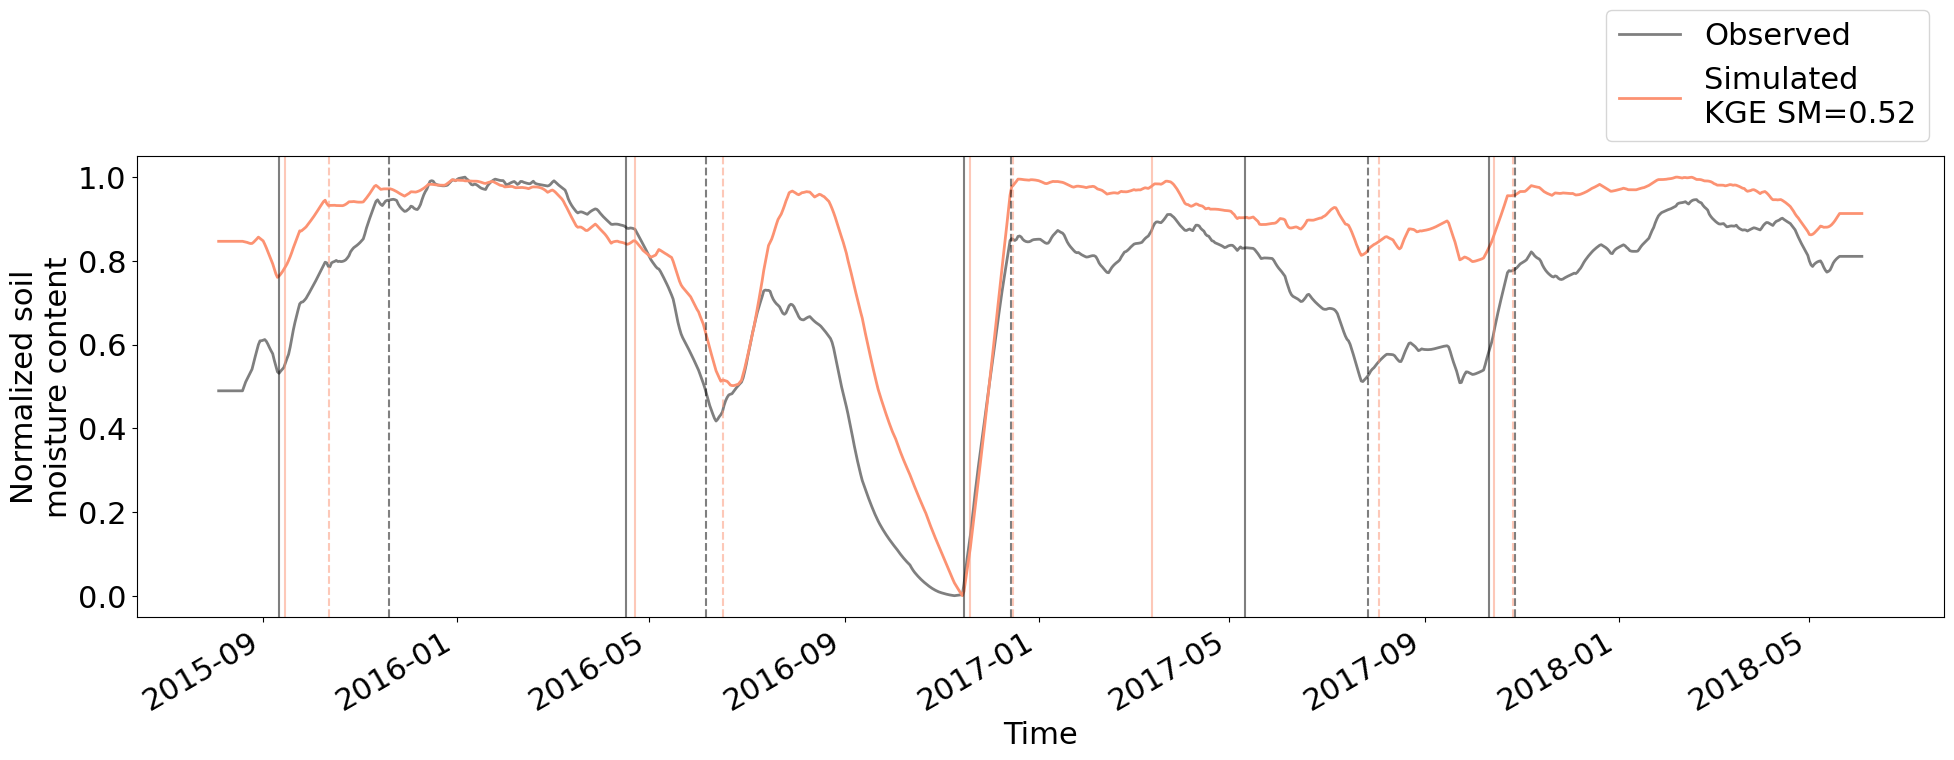

In [412]:
# Relative values of SM 
# Plot out the results
df_obs = obs_synced
df_sim = sim_synced
obs_label = 'Observed'
sim_label = f'Simulated\nKGE SM={KGESM_for_the_run:.2f}'
obs_color = 'k'
sim_color = '#fc9272'
y_label = 'Volumetric Soil Moisture Content [m^3/m^3]'
title = 'Soil moisture and seasonal transition signatures'
fn = 'timeseries.pdf'

f2 = plt.figure(figsize=(20, 8))
ax3 = f2.add_subplot()
plt.rc('font', size=22)
x_obs = sig_obs.tt.index
y_obs = (sig_obs.tt.values-min(sig_obs.tt.values))/(max(sig_obs.tt.values)-min(sig_obs.tt.values))
x_sim = sig_sim.tt.index
y_sim = (sig_sim.tt.values-min(sig_sim.tt.values))/(max(sig_sim.tt.values)-min(sig_sim.tt.values))
xlim_start = 0 #60
xlim_end = len(x_obs) #-60
ax3.plot(x_obs[xlim_start:xlim_end], y_obs[xlim_start:xlim_end], alpha=0.5, label=obs_label, color=obs_color, linewidth=2)
ax3.plot(x_sim[xlim_start:xlim_end], y_sim[xlim_start:xlim_end], alpha=1, label=sim_label, color=sim_color, linewidth=2)

import numpy as np
from datetime import datetime, timedelta
def julian_to_datetime(jd):
    try:
        return datetime(1, 1, 1) + timedelta(days=jd - 1721425)
    except Exception as e:
        # Return np.nan if there's an error
        return np.nan

stard_dates_jd = np.concatenate([season_trans_obs[:, 0], season_trans_obs[:, 2]])
start_dates_obs = [julian_to_datetime(jd) for jd in stard_dates_jd]
end_dates_jd = np.concatenate([season_trans_obs[:, 1], season_trans_obs[:, 3]])
end_dates_obs = [julian_to_datetime(jd) for jd in end_dates_jd]

stard_dates_jd_sim = np.concatenate([season_trans_sim[:, 0], season_trans_sim[:, 2]])
start_dates_sim = [julian_to_datetime(jd) for jd in stard_dates_jd_sim]
end_dates_jd_sim = np.concatenate([season_trans_sim[:, 1], season_trans_sim[:, 3]])
end_dates_sim = [julian_to_datetime(jd) for jd in end_dates_jd_sim]

for i in range(len(start_dates_obs)):
    ax3.axvline(x=start_dates_obs[i], color=obs_color, label=None, alpha=0.5, linestyle='-')
for i in range(len(end_dates_obs)):
    ax3.axvline(x=end_dates_obs[i], color=obs_color, label=None, alpha=0.5, linestyle='--')
for i in range(len(start_dates_sim)):
    ax3.axvline(x=start_dates_sim[i], color=sim_color, label=None, alpha=0.5, linestyle='-')
for i in range(len(end_dates_sim)):
    ax3.axvline(x=end_dates_sim[i], color=sim_color, label=None, alpha=0.5, linestyle='--')
ax3.set_xlabel('Time')
from datetime import datetime
ax3.set_ylabel('Normalized soil\nmoisture content')
# ax3.set_title(title)
ax3.legend(loc='lower right', bbox_to_anchor=(1,1))
plt.tight_layout()
f2.autofmt_xdate()
f2.savefig(os.path.join(out_path, fn), dpi=600, bbox_inches='tight')

In [413]:
start_dates_obs

[datetime.datetime(2015, 9, 10, 17, 46, 7, 249739),
 datetime.datetime(2016, 11, 15, 6, 12, 22, 709309),
 datetime.datetime(2017, 10, 11, 11, 20, 30, 414180),
 datetime.datetime(2016, 4, 16, 8, 39, 4, 633041),
 datetime.datetime(2017, 5, 11, 1, 35, 38, 715363),
 nan]

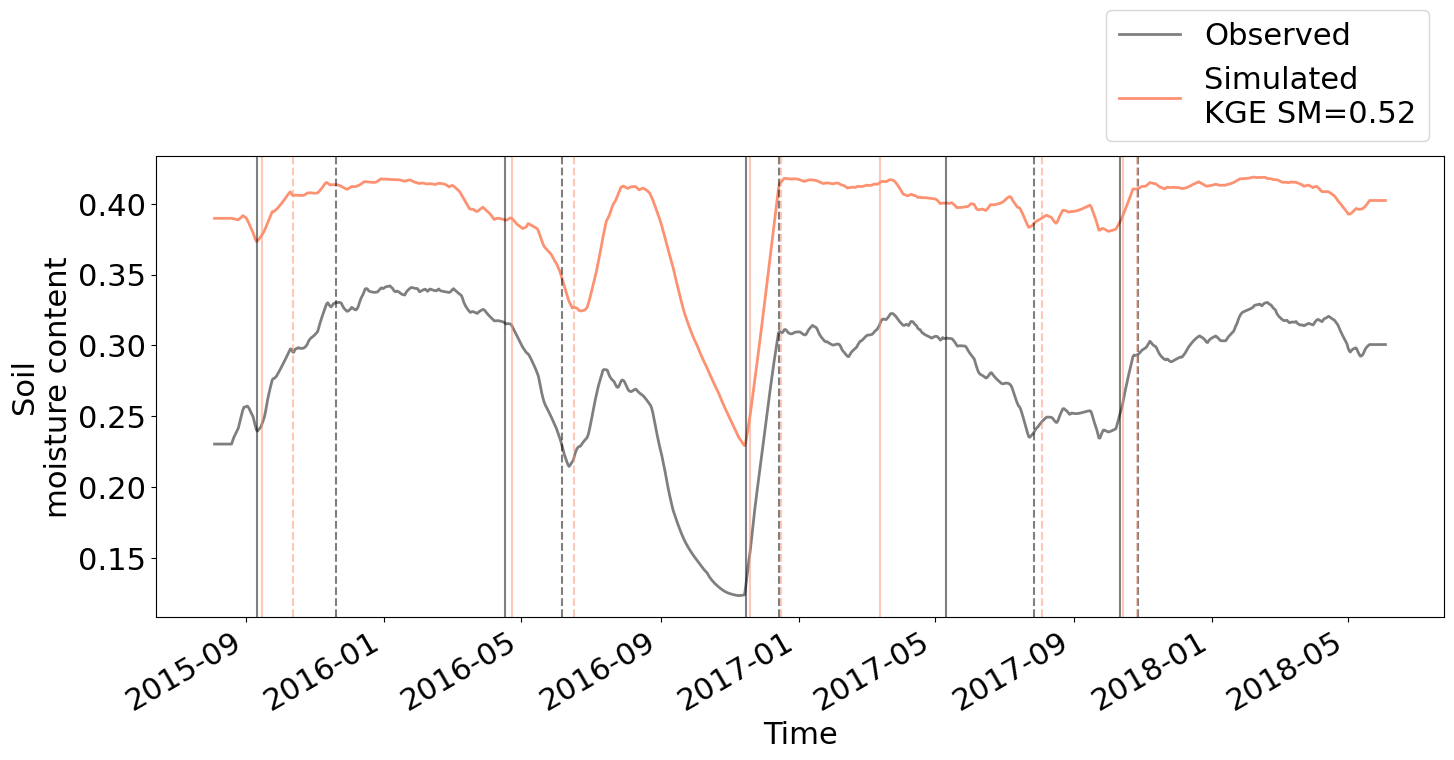

In [414]:
# Relative values of SM 
# Plot out the results
df_obs = obs_synced
df_sim = sim_synced
obs_label = 'Observed'
sim_label = f'Simulated\nKGE SM={KGESM_for_the_run:.2f}'
obs_color = 'k'
sim_color = '#fc9272'
y_label = 'Volumetric Soil Moisture Content [m^3/m^3]'
title = 'Soil moisture and seasonal transition signatures'
fn = 'timeseries.pdf'

f2 = plt.figure(figsize=(15, 8))
ax3 = f2.add_subplot()
plt.rc('font', size=22)
x_obs = sig_obs.tt.index
y_obs = sig_obs.tt.values
x_sim = sig_sim.tt.index
y_sim = sig_sim.tt.values
xlim_start = 0
xlim_end = len(x_obs)
ax3.plot(x_obs[xlim_start:xlim_end], y_obs[xlim_start:xlim_end], alpha=0.5, label=obs_label, color=obs_color, linewidth=2)
ax3.plot(x_sim[xlim_start:xlim_end], y_sim[xlim_start:xlim_end], alpha=1, label=sim_label, color=sim_color, linewidth=2)
for i in range(len(start_dates_obs)):
    ax3.axvline(x=start_dates_obs[i], color=obs_color, label=None, alpha=0.5, linestyle='-')
for i in range(len(end_dates_obs)):
    ax3.axvline(x=end_dates_obs[i], color=obs_color, label=None, alpha=0.5, linestyle='--')
for i in range(len(start_dates_sim)):
    ax3.axvline(x=start_dates_sim[i], color=sim_color, label=None, alpha=0.5, linestyle='-')
for i in range(len(end_dates_sim)):
    ax3.axvline(x=end_dates_sim[i], color=sim_color, label=None, alpha=0.5, linestyle='--')
ax3.set_xlabel('Time')
from datetime import datetime
ax3.set_ylabel('Soil\nmoisture content')
# ax3.set_ylim([0.30, 0.65])
# ax3.set_xlim(datetime(1998, 1,1), datetime(2001, 9, 30))
ax3.legend(loc='lower right', bbox_to_anchor=(1,1))
plt.tight_layout()
f2.autofmt_xdate()
f2.savefig(os.path.join(out_path, fn), dpi=600, bbox_inches='tight')

sig_sim.tt.to_csv(os.path.join(out_path, 'simulated.csv'))
sig_obs.tt.to_csv(os.path.join(out_path, 'observed.csv'))